In [1]:
import sys
from pathlib import Path

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import spaces
from tqdm import trange

from flygym import Fly, Camera
from flygym.examples.turning_controller import HybridTurningNMF
from flygym.examples.vision import MovingObjArena
from flygym.vision import save_video_with_vision_insets

In [2]:
try:
    stable = bool(int(sys.argv[-1]))
except (IndexError, ValueError):
    stable = True

In [3]:
class VisualTaxis(HybridTurningNMF):
    def __init__(
        self, camera: Camera, obj_threshold=0.15, decision_interval=0.05, **kwargs
    ):
        super().__init__(cameras=[camera], **kwargs)

        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / self.timestep)
        self.visual_inputs_hist = []
        self.second_cam_frames = []

        self.coms = np.empty((self.fly.retina.num_ommatidia_per_eye, 2))
        for i in range(self.fly.retina.num_ommatidia_per_eye):
            mask = self.fly.retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

        self.observation_space = spaces.Box(0, 1, shape=(6,))

    def step(self, control_signal):
        vision_inputs = []
        for _ in range(self.num_substeps):
            raw_obs, _, _, _, info = super().step(control_signal)
            if info["vision_updated"]:
                vision_inputs.append(raw_obs["vision"])
            render_res = super().render()[0]
            if render_res is not None:
                # record visual inputs too because they will be played in the video
                self.visual_inputs_hist.append(raw_obs["vision"].copy())

                second_cam = self.physics.bind(self.arena.birdeye_cam_zoom)
                second_cam.pos[0] = self.arena.ball_pos[0] - 2
                second_img = self.physics.render(
                    width=700, height=560, camera_id="birdeye_cam_zoom"
                )
                second_img = cv2.putText(
                    np.ascontiguousarray(second_img),
                    f"{self.cameras[0].play_speed}x",
                    org=(20, 30),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=0.8,
                    color=(0, 0, 0),
                    lineType=cv2.LINE_AA,
                    thickness=1,
                )
                self.second_cam_frames.append(second_img)
        median_vision_input = np.median(vision_inputs, axis=0)
        visual_features = self._process_visual_observation(median_vision_input)
        return visual_features, 0, False, False, {}

    def _process_visual_observation(self, vision_input):
        features = np.zeros((2, 3))
        for i, ommatidia_readings in enumerate(vision_input):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj_coords = self.coms[is_obj]
            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
            features[i, 2] = is_obj_coords.shape[0]
        features[:, 0] /= self.fly.retina.nrows  # normalize y_center
        features[:, 1] /= self.fly.retina.ncols  # normalize x_center
        features[:, 2] /= self.fly.retina.num_ommatidia_per_eye  # normalize area
        return features.ravel().astype("float32")

    def reset(self, seed=0, **kwargs):
        raw_obs, _ = super().reset(seed=seed)
        self.visual_inputs_hist = []
        return self._process_visual_observation(raw_obs["vision"]), {}

In [4]:
arena = MovingObjArena()

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

fly = Fly(
    contact_sensor_placements=contact_sensor_placements,
    enable_adhesion=True,
    enable_vision=True,
    non_actuated_joint_stiffness=1 if stable else 1000,
    head_stabilization_model="thorax" if stable else None,
    neck_kp=1000 if stable else 0,
)

cam = Camera(
    fly=fly,
    camera_id="birdeye_cam",
    window_size=(700, 560),
    fps=30,
    play_speed=0.5,
)

obj_threshold = 0.2
decision_interval = 0.025

sim = VisualTaxis(
    fly=fly,
    camera=cam,
    arena=arena,
    obj_threshold=obj_threshold,
    decision_interval=decision_interval,
    intrinsic_freqs=np.ones(6) * 9,
)

In [5]:
def calc_ipsilateral_speed(deviation, is_found):
    if not is_found:
        return 1.0
    else:
        return np.clip(1 - deviation * 3, 0.4, 1.2)

In [6]:
num_substeps = int(decision_interval / sim.timestep)

obs_hist = []
deviations_hist = []
control_signal_hist = []
raw_visual_hist = []

obs, _ = sim.reset(seed=0)
for i in trange(200):
    left_deviation = 1 - obs[1]
    right_deviation = obs[4]
    left_found = obs[2] > 0.01
    right_found = obs[5] > 0.01
    if not left_found:
        left_deviation = np.nan
    if not right_found:
        right_deviation = np.nan
    control_signal = np.array(
        [
            calc_ipsilateral_speed(left_deviation, left_found),
            calc_ipsilateral_speed(right_deviation, right_found),
        ]
    )

    obs = sim.step(control_signal)[0]
    obs_hist.append(obs)
    raw_visual_hist.append(fly._curr_visual_input.copy())
    deviations_hist.append([left_deviation, right_deviation])
    control_signal_hist.append(control_signal)

100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


In [7]:
birdeye_cam_frames = cam._frames
cam._frames = sim.second_cam_frames

In [8]:
save_video_with_vision_insets(
    sim,
    cam,
    "./outputs/object_following_with_retina_images.mp4",
    sim.visual_inputs_hist,
    stabilization_time=0.05,
)

[swscaler @ 0x5653b80] Warning: data is not aligned! This can lead to a speed loss


In [9]:
save_individual_frames = False
individual_frames_dir = Path("outputs/individual_frames")

snapshot_interval_frames = 32

frames_indices = np.arange(0, len(birdeye_cam_frames), snapshot_interval_frames)[:8]
snapshots = np.array([birdeye_cam_frames[i] for i in frames_indices])
background = np.median(snapshots, axis=0).astype(np.uint8)

if save_individual_frames:
    individual_frames_dir.mkdir(parents=True, exist_ok=True)
    imageio.imwrite(individual_frames_dir / "background.png", background)

imgs = []

for i in trange(0, snapshots.shape[0]):
    img = snapshots[i, :, :, :]
    is_background = np.isclose(img, background, atol=1).all(axis=2)
    img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
    img_alpha[:, :, :3] = img
    img_alpha[is_background, 3] = 0
    img_alpha = img_alpha.astype(np.uint8)
    imgs.append(img_alpha)

    if save_individual_frames:
        imageio.imwrite(individual_frames_dir / f"frame_{i}.png", img_alpha)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 90.43it/s]


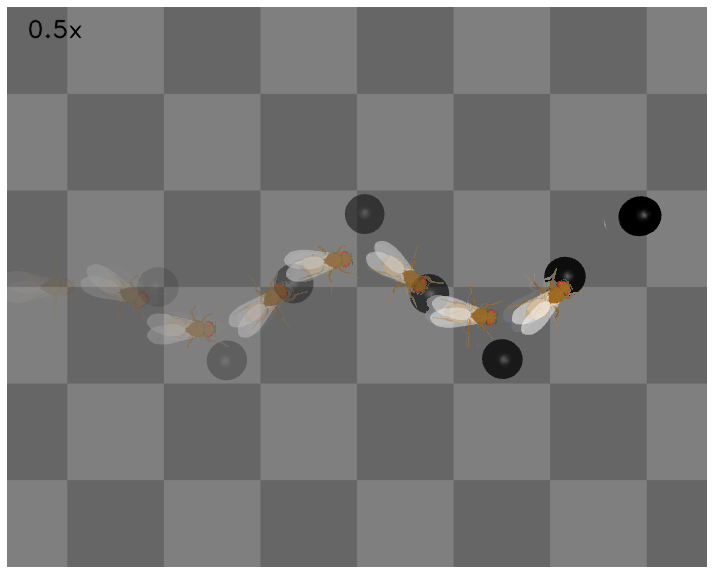

In [10]:
dpi = 72
h, w = background.shape[:2]

fig, ax = plt.subplots(figsize=(w / dpi, h / dpi), dpi=72)
ax.imshow(background)
ax.axis("off")

for i, img in enumerate(imgs):
    ax.imshow(img, alpha=(i + 1) / len(imgs))

fig.subplots_adjust(0, 0, 1, 1, 0, 0)
plt.savefig("outputs/visual_taxis.pdf", dpi=dpi)